### notebook requirements:

The main requirement is simply `yt` (`pip install yt`).

The graph generated in the first cell also requires [`inheritance explorer`](https://inheritance-explorer.readthedocs.io/en/latest/) with [`graphviz`](https://graphviz.org/download/). 

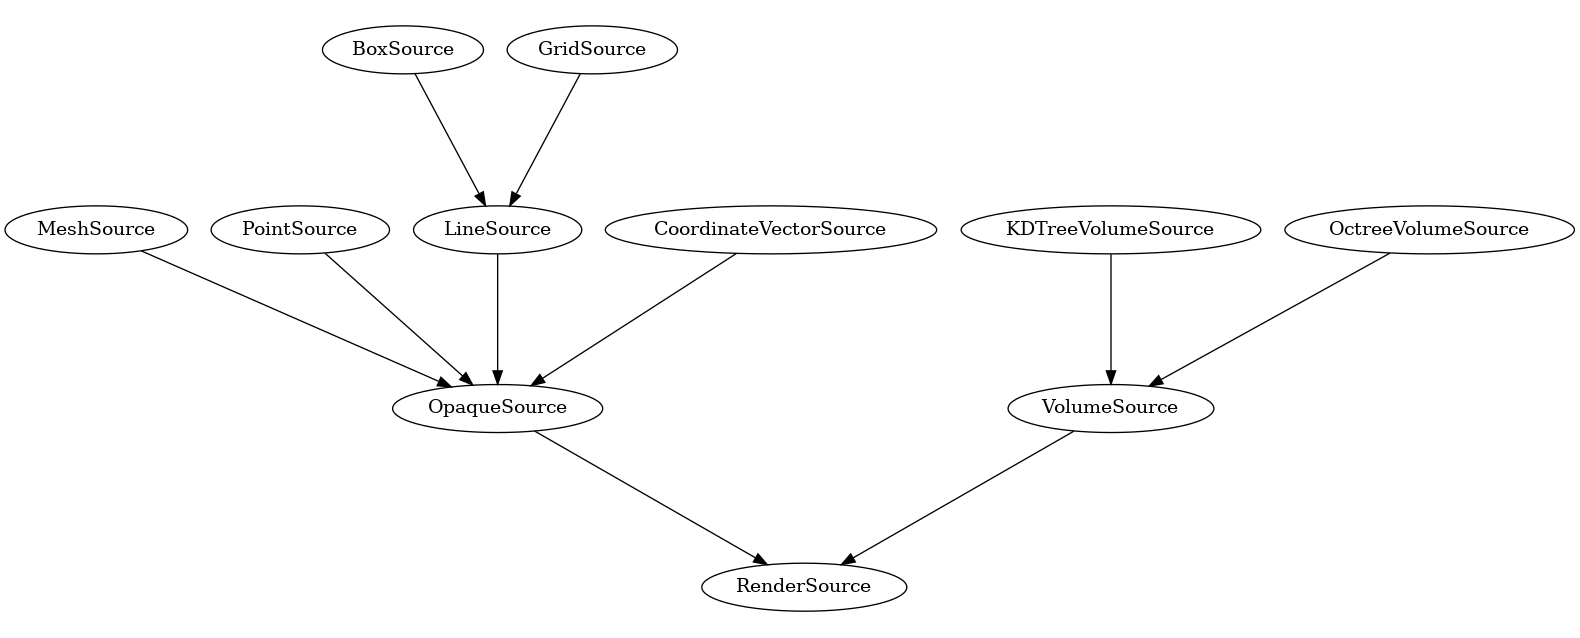

In [1]:
import inheritance_explorer as ie 
from yt.visualization.volume_rendering.render_source import RenderSource
rs = ie.ClassGraphTree(RenderSource)
rs.show_graph(ratio=.4)


### base volume rendering 

yt : [INFO     ] 2023-11-10 16:09:32,238 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2023-11-10 16:09:32,239 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2023-11-10 16:09:32,239 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-10 16:09:32,240 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-11-10 16:09:32,242 Parameters: cosmological_simulation   = 0
Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 22026.37it/s]
yt : [INFO     ] 2023-11-10 16:09:32,263 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2023-11-10 16:09:33,248 Setting default field to ('gas', 'density')
yt : [INFO     ] 2023-11-10 16:09:33,251 Rendering scene (Can take a while).
yt : [INFO     ] 2023-11-10 16:09:33,253 Creating volume
yt : [INFO     ] 2023-11-10 16:09:35,392 Creating transfer function
yt : [

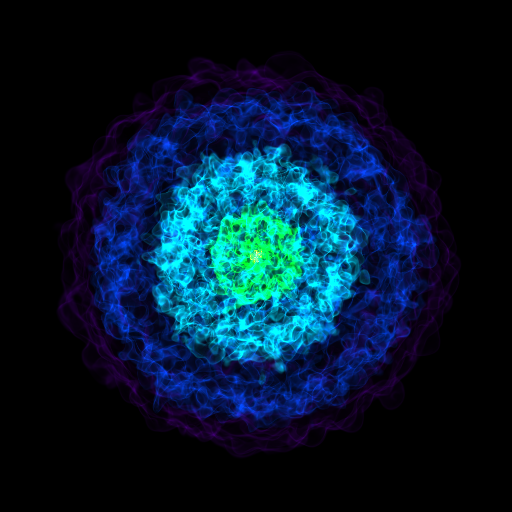

In [2]:
import yt
from yt.units import Mpc
from yt.visualization.api import Streamlines
from yt.visualization.volume_rendering.api import LineSource
import numpy as np 

# Load the dataset
ds = yt.load("IsolatedGalaxy/galaxy0030/galaxy0030")
sc = yt.create_scene(ds)
sc.camera.zoom(3)
sc.show(sigma_clip=4)

### adding connected line segments with `LineSource`

In [3]:
import numpy as np 
vertices = []
vert = ([0.5, 0.5, 0.5], [0.6, 0.52, 0.52])
vertices.append(vert)
vert_2 = (vert[-1], [0.3, 0.2, 0.48])
vertices.append(vert_2)
vertices = np.array(vertices)
vertices

array([[[0.5 , 0.5 , 0.5 ],
        [0.6 , 0.52, 0.52]],

       [[0.6 , 0.52, 0.52],
        [0.3 , 0.2 , 0.48]]])

yt : [INFO     ] 2023-11-10 16:09:39,060 Rendering scene (Can take a while).


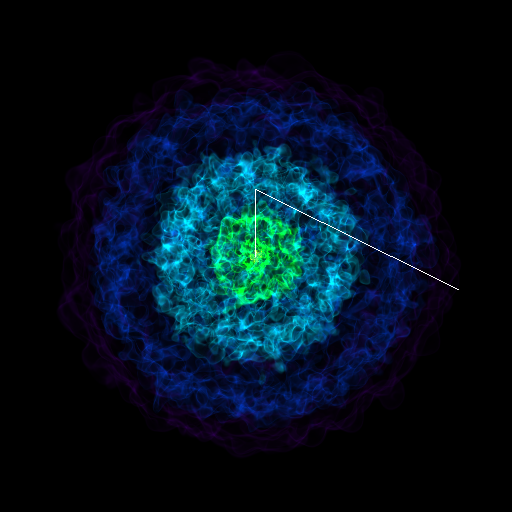

In [4]:
colors = np.ones([vertices.shape[0], 4])    
colors[:, -1] = 0.1
ls = LineSource(vertices, colors)    
sc.add_source(ls)
sc.render()
sc.show(sigma_clip=4)

### adding a "continuous" curve

define a circle in x-z fixed z

In [5]:
r = 0.1
theta = np.linspace(0, np.pi*2, 100)
x = r * np.cos(theta) + 0.5
y = r * np.sin(theta) + 0.5
z = np.full(x.shape, 0.5)
pos = np.column_stack([x, y, z])
print(pos[:3])

[[0.6        0.5        0.5       ]
 [0.59979867 0.50634239 0.5       ]
 [0.59919548 0.51265925 0.5       ]]


function to split the curve into a series of line segments

In [6]:
def segment_a_curve(pos_i):
    index_range = np.arange(0, pos_i.shape[0])
    line_indices = np.column_stack([index_range, index_range]).ravel()[1:-1]

    line_segments = pos_i[line_indices, :]
    n_line_segments = int(line_segments.size/6)
    return line_segments.reshape((n_line_segments, 2, 3))

In [7]:
segmented = segment_a_curve(pos)
print(segmented[:3])

[[[0.6        0.5        0.5       ]
  [0.59979867 0.50634239 0.5       ]]

 [[0.59979867 0.50634239 0.5       ]
  [0.59919548 0.51265925 0.5       ]]

 [[0.59919548 0.51265925 0.5       ]
  [0.59819287 0.51892512 0.5       ]]]


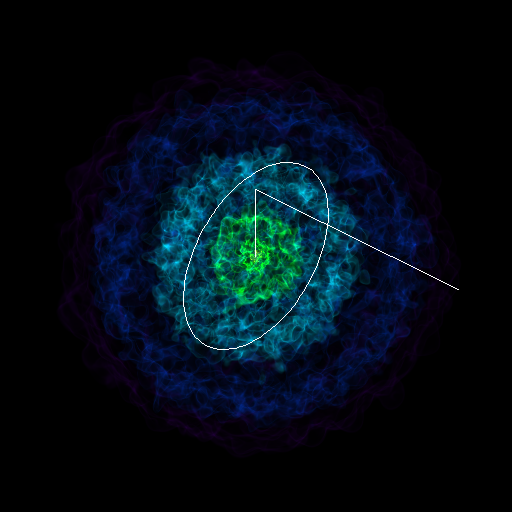

In [8]:
colors = np.ones([segmented.shape[0], 4])    
colors[:, -1] = 0.1
ls = LineSource(segmented, colors)    
sc.add_source(ls)
sc.render()
sc.show(sigma_clip=4)

### adding streamlines

First, generate the streamlines. We'll choose starting points randomly within 0.1-0.2 of the domain center

In [9]:
def get_streamline_starting_pos(N):    
    c = ds.domain_center
    rng = np.random.default_rng()
    r = rng.uniform(low=0.1, high=0.2, size=(N,)) 
    theta = rng.uniform(low=0, high=2*np.pi, size=(N,)) 
    phi = rng.uniform(low=0, high=np.pi, size=(N,)) 

    z = r * np.cos(phi)
    xy = r * np.sin(phi)
    x = xy * np.cos(theta)
    y = xy * np.sin(theta)

    offset = np.column_stack([x, y, z])
    pos = c + ds.arr(offset, 'code_length')
    return pos

pos = get_streamline_starting_pos(10)
# the box defined above


Build an `AMRKDTree` volume to re-use between `Streamlines` objects:

In [10]:
from yt.utilities.amr_kdtree.api import AMRKDTree

x_field = ("gas", "velocity_x")
y_field = ("gas", "velocity_y")
z_field = ("gas", "velocity_z")

volume = AMRKDTree(ds)
volume.set_fields(
    [x_field, y_field, z_field], [False, False, False], False
)
volume.join_parallel_trees()

yt : [INFO     ] 2023-11-10 16:10:41,112 AMRKDTree rebuilt, Final Volume: 1.000000e+00


In [11]:

streamlines = Streamlines(
    ds,
    pos,
    x_field, y_field, z_field,
    length=1.0 * Mpc,
    get_magnitude=True,
    volume=volume
)
streamlines.integrate_through_volume()

Streamlining: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.70it/s]


yt : [INFO     ] 2023-11-10 16:10:43,254 Setting default field to ('gas', 'density')
yt : [INFO     ] 2023-11-10 16:10:43,266 Rendering scene (Can take a while).
yt : [INFO     ] 2023-11-10 16:10:43,308 Creating volume
yt : [INFO     ] 2023-11-10 16:10:45,092 Creating transfer function
yt : [INFO     ] 2023-11-10 16:10:45,092 Calculating data bounds. This may take a while. Set the TransferFunctionHelper.bounds to avoid this.


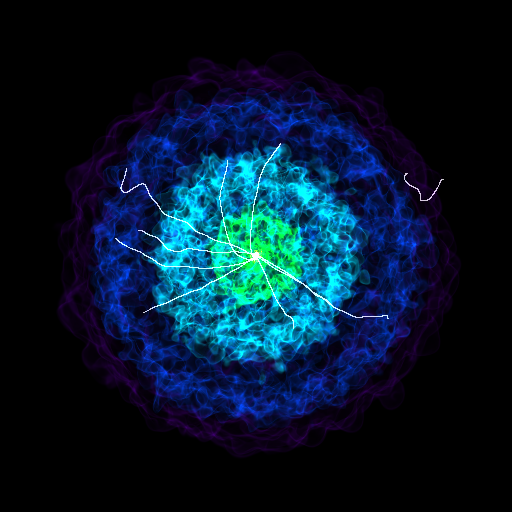

In [12]:
sc = yt.create_scene(ds)
sc.camera.zoom(3)

for streamline in streamlines.streamlines:
    segmented_streamlines = segment_a_curve(streamline)
    colors = np.ones([segmented_streamlines.shape[0], 4])    
    colors[:, -1] = 0.01
    ls = LineSource(segmented_streamlines, colors)    
    sc.add_source(ls)
    
sc.render()
sc.show(sigma_clip=4)

### lots of streamlines?

In [13]:
pos = get_streamline_starting_pos(500)
pos.shape

(500, 3)

In [14]:
streamlines = Streamlines(
    ds,
    pos,
    x_field, y_field, z_field,
    length=1.0 * Mpc,
    get_magnitude=True,
    volume=volume
)

In [15]:
streamlines.integrate_through_volume()

Streamlining: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:41<00:00,  4.91it/s]


yt : [INFO     ] 2023-11-10 16:12:30,976 Setting default field to ('gas', 'density')
yt : [INFO     ] 2023-11-10 16:12:31,115 Rendering scene (Can take a while).
yt : [INFO     ] 2023-11-10 16:12:32,509 Creating volume
yt : [INFO     ] 2023-11-10 16:12:34,407 Creating transfer function
yt : [INFO     ] 2023-11-10 16:12:34,407 Calculating data bounds. This may take a while. Set the TransferFunctionHelper.bounds to avoid this.


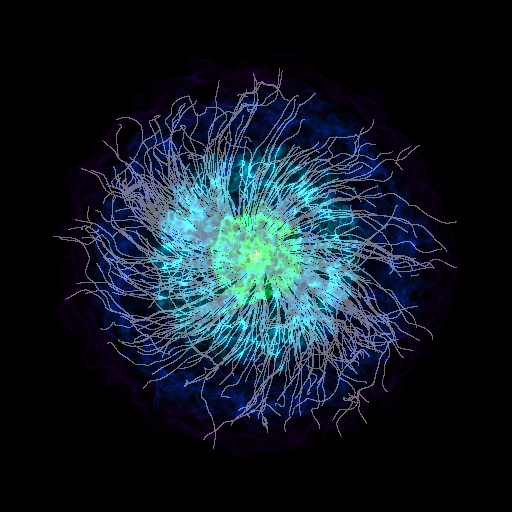

In [16]:
sc = yt.create_scene(ds)
sc.camera.zoom(3)

for streamline in streamlines.streamlines:
    segmented_streamlines = segment_a_curve(streamline)
    colors = np.ones([segmented_streamlines.shape[0], 4])    
    colors[:, -1] = 0.01
    ls = LineSource(segmented_streamlines, colors)    
    sc.add_source(ls)
    
sc.render()
sc.show(sigma_clip=4)